In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect


In [2]:
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns

from difflib import SequenceMatcher
import re


%matplotlib inline

In [3]:
engine = create_engine("sqlite:///get_mta/mta_data.db")

In [4]:
insp = inspect(engine)
print(insp.get_table_names())

['mta_data']


In [5]:
mta_df = pd.read_sql('SELECT*FROM mta_data', engine)

In [ ]:
# with open('mta_df.pickle', 'rb') as read_file:
#     mta_df = pickle.load(read_file)

 # Initial Data Inspection

In [ ]:
mta_df.head()

In [ ]:
mta_df.tail()

In [ ]:
mta_df.shape

In [ ]:
mta_df.info()

In [ ]:

mta_df.isna().sum()

# Data Formatting


In [6]:
mta_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [7]:
# Need to insure that all column names are correctly and consistently formatted
mta_df.columns = [column.strip() for column in mta_df.columns]
mta_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [8]:
mta_df.DATE.value_counts().sort_index()

02/27/2021    29985
02/28/2021    29763
03/01/2021    29868
03/02/2021    29803
03/03/2021    29871
              ...  
06/14/2021    29852
06/15/2021    29989
06/16/2021    29910
06/17/2021    29959
06/18/2021    29812
Name: DATE, Length: 112, dtype: int64

In [9]:
import datetime

In [10]:
# Data & Time column datatype is "object" must convert to "datetime" for efficiency 
mta_df["DATE_TIME"] = pd.to_datetime(mta_df["DATE"] + " " + mta_df["TIME"], format="%m/%d/%Y %H:%M:%S")
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,00:00:00,REGULAR,7585482,2593043,2021-06-12 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,2593043,2021-06-12 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,2593050,2021-06-12 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,2593066,2021-06-12 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,2593068,2021-06-12 16:00:00


In [ ]:
# # Station column does not identify unique station, must combine with linename

# mta_df['STATION'] = mta_df['STATION'] + ' ' + mta_df['LINENAME']
# mta_df.head()

In [11]:
# Adding turnstile column

mta_df['TURNSTILE'] = mta_df['C/A'] + ' ' + mta_df['UNIT'] + ' ' + mta_df['SCP'] + ' ' + mta_df['STATION']

mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,00:00:00,REGULAR,7585482,2593043,2021-06-12 00:00:00,A002 R051 02-00-00 59 ST
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,04:00:00,REGULAR,7585492,2593043,2021-06-12 04:00:00,A002 R051 02-00-00 59 ST
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,08:00:00,REGULAR,7585498,2593050,2021-06-12 08:00:00,A002 R051 02-00-00 59 ST
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,12:00:00,REGULAR,7585546,2593066,2021-06-12 12:00:00,A002 R051 02-00-00 59 ST
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/12/2021,16:00:00,REGULAR,7585641,2593068,2021-06-12 16:00:00,A002 R051 02-00-00 59 ST


# Data Cleaning


In [12]:
# Check for duplicates by insuring that each entry by turnstile and 'DATE_TIME' are unique
(mta_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)


,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
283744,B024,R211,00-05-00,KINGS HWY,2021-05-01 08:00:00,2
2223990,R138,R293,00-02-02,34 ST-PENN STA,2021-02-28 09:00:00,2
283763,B024,R211,00-05-00,KINGS HWY,2021-05-04 12:00:00,2
283762,B024,R211,00-05-00,KINGS HWY,2021-05-04 08:00:00,2
283760,B024,R211,00-05-00,KINGS HWY,2021-05-04 00:00:00,2


In [13]:
# Appears we have duplicate entries for multiple stations and dates...lets investigate
mask_1 = ((mta_df["C/A"] == "B024") & 
(mta_df["UNIT"] == "R211") & 
(mta_df["SCP"] == "00-05-00") & 
(mta_df["STATION"] == "KINGS HWY BQ") &
(mta_df["DATE_TIME"].dt.date == datetime.datetime(2021, 5, 1).date()))
          
mta_df[mask_1].head()          

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE


In [14]:
# Duplication due to "Recovery Audits", lets drop duplicates

mta_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)

mta_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE
209259,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,21:00:00,REGULAR,5554,584,2021-06-18 21:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT
209258,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,17:00:00,REGULAR,5554,584,2021-06-18 17:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT
209257,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,13:00:00,REGULAR,5554,584,2021-06-18 13:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT
209256,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,09:00:00,REGULAR,5554,584,2021-06-18 09:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT
209255,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,05:00:00,REGULAR,5554,584,2021-06-18 05:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT


In [15]:
#Insure that duplicates were dropped

mta_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"]).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-02-27 03:00:00,1
2230654,R138,R293,00-05-00,34 ST-PENN STA,2021-06-03 18:00:00,1
2230644,R138,R293,00-05-00,34 ST-PENN STA,2021-06-02 02:00:00,1
2230645,R138,R293,00-05-00,34 ST-PENN STA,2021-06-02 06:00:00,1
2230646,R138,R293,00-05-00,34 ST-PENN STA,2021-06-02 10:00:00,1


In [16]:
mta_daily = (mta_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,02/27/2021,7537589
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503


In [17]:
# "Entries" contains cumulative entries, must find daily entries

mta_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .shift(1))
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,02/27/2021,7537589,NaN,NaN
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852,02/27/2021,7537589.0
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400,02/28/2021,7537852.0
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926,03/01/2021,7538400.0
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503,03/02/2021,7538926.0


In [18]:
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [19]:
#Why are there negative values
(mta_daily["ENTRIES"] - mta_daily["PREV_ENTRIES"]).describe()

count    5.541530e+05
mean    -2.260900e+03
std      5.947422e+06
min     -1.604323e+09
25%      6.500000e+01
50%      2.270000e+02
75%      4.650000e+02
max      2.139011e+09
dtype: float64

In [20]:
# counters are in reverse?
mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
471,A002,R051,02-03-02,59 ST,03/22/2021,238,03/21/2021,6641395.0
4369,A011,R080,01-03-00,57 ST-7 AV,02/28/2021,885620240,02/27/2021,885620355.0
4370,A011,R080,01-03-00,57 ST-7 AV,03/01/2021,885620021,02/28/2021,885620240.0
4371,A011,R080,01-03-00,57 ST-7 AV,03/02/2021,885619834,03/01/2021,885620021.0
4372,A011,R080,01-03-00,57 ST-7 AV,03/03/2021,885619673,03/02/2021,885619834.0


In [21]:
(mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A002   R051  02-03-02  59 ST                1
A011   R080  01-03-00  57 ST-7 AV         111
             01-03-03  57 ST-7 AV           1
             01-03-04  57 ST-7 AV           1
A013   R081  01-06-01  49 ST                1
                                         ... 
R622   R123  00-00-00  FRANKLIN AV        110
R624   R124  00-00-02  KINGSTON AV          1
R730   R431  00-00-04  EASTCHSTER/DYRE    110
S101   R070  00-00-04  ST. GEORGE           1
TRAM2  R469  00-05-00  RIT-ROOSEVELT        1
Length: 237, dtype: int64

In [22]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

mta_daily["DAILY_ENTRIES"] = mta_daily.apply(get_daily_counts, axis=1, max_counter=40000)

In [23]:
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852,02/27/2021,7537589.0,263.0
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400,02/28/2021,7537852.0,548.0
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926,03/01/2021,7538400.0,526.0
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503,03/02/2021,7538926.0,577.0
5,A002,R051,02-00-00,59 ST,03/04/2021,7540040,03/03/2021,7539503.0,537.0


In [24]:
ca_unit_station_daily = mta_daily.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
ca_unit_station_daily.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,02/28/2021,2002.0
1,A002,R051,59 ST,03/01/2021,4187.0
2,A002,R051,59 ST,03/02/2021,4459.0
3,A002,R051,59 ST,03/03/2021,4575.0
4,A002,R051,59 ST,03/04/2021,4526.0


In [25]:
# Get daily entries by station

stations_daily = \
(mta_daily.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum()
                 .reset_index())

stations_daily

,STATION,DATE,DAILY_ENTRIES
0,1 AV,02/28/2021,3639.0
1,1 AV,03/01/2021,6086.0
2,1 AV,03/02/2021,6254.0
3,1 AV,03/03/2021,6557.0
4,1 AV,03/04/2021,6506.0
...,...,...,...
41977,ZEREGA AV,06/14/2021,1169.0
41978,ZEREGA AV,06/15/2021,1228.0
41979,ZEREGA AV,06/16/2021,1158.0
41980,ZEREGA AV,06/17/2021,1202.0


In [26]:

# (sum across all days is a reasonable way to define this)
top10_stations = \
    (stations_daily.groupby(['STATION'])[['DAILY_ENTRIES']].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False) 
                   .STATION.head(10))
top10_stations

61      34 ST-PENN STA
59     34 ST-HERALD SQ
110              86 ST
9               125 ST
233    GRD CNTRL-42 ST
68     42 ST-PORT AUTH
46               23 ST
14      14 ST-UNION SQ
217      FLUSHING-MAIN
85               59 ST
Name: STATION, dtype: object

In [27]:
station_daily_top10 = \
    stations_daily[stations_daily['STATION'].isin(top10_stations)].sort_values(by = 'DAILY_ENTRIES', ascending = False)

In [28]:
station_daily_top10

,STATION,DATE,DAILY_ENTRIES
6856,34 ST-PENN STA,05/24/2021,223926.0
25962,GRD CNTRL-42 ST,06/11/2021,71390.0
1072,125 ST,05/12/2021,61392.0
6880,34 ST-PENN STA,06/17/2021,49903.0
6881,34 ST-PENN STA,06/18/2021,49463.0
...,...,...,...
25873,GRD CNTRL-42 ST,03/14/2021,8371.0
9449,59 ST,03/14/2021,8101.0
25859,GRD CNTRL-42 ST,02/28/2021,7610.0
24131,FLUSHING-MAIN,04/17/2021,2050.0


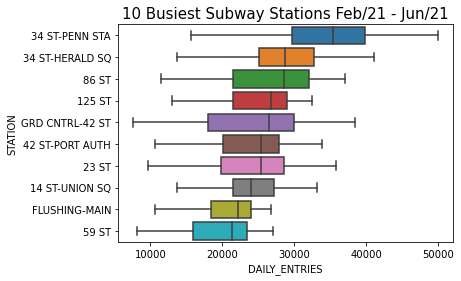

In [29]:
sns.boxplot(x='DAILY_ENTRIES', y='STATION', data=station_daily_top10, order = top10_stations, \
            showfliers = False).set_title('10 Busiest Subway Stations Feb/21 - Jun/21', size = 15);

In [30]:
# # Get top stations, sorted by entries
# station_totals = stations_daily.groupby(['STATION'])['DAILY_ENTRIES'].sum()\
#                    .reset_index()\
#                    .sort_values(by='DAILY_ENTRIES',ascending=False) 


## TOP 5 BUSIEST STATIONS:  BUSIEST TIME SLOTS

In [31]:
turnstile_df = mta_df.copy()
turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE
209259,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,21:00:00,REGULAR,5554,584,2021-06-18 21:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT
209258,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,17:00:00,REGULAR,5554,584,2021-06-18 17:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT
209257,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,13:00:00,REGULAR,5554,584,2021-06-18 13:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT
209256,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,09:00:00,REGULAR,5554,584,2021-06-18 09:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT
209255,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,05:00:00,REGULAR,5554,584,2021-06-18 05:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT


In [32]:
turnstile_df[['PREV_TIME', 'PREV_ENTRIES']] = (turnstile_df.groupby('TURNSTILE')[['TIME','ENTRIES']].shift(-1))
turnstile_df.head()                                                                      

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE,PREV_TIME,PREV_ENTRIES
209259,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,21:00:00,REGULAR,5554,584,2021-06-18 21:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT,17:00:00,5554.0
209258,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,17:00:00,REGULAR,5554,584,2021-06-18 17:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT,13:00:00,5554.0
209257,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,13:00:00,REGULAR,5554,584,2021-06-18 13:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT,09:00:00,5554.0
209256,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,09:00:00,REGULAR,5554,584,2021-06-18 09:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT,05:00:00,5554.0
209255,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,05:00:00,REGULAR,5554,584,2021-06-18 05:00:00,TRAM2 R469 00-05-01 RIT-ROOSEVELT,01:00:00,5554.0


In [33]:
(turnstile_df["ENTRIES"] - turnstile_df["PREV_ENTRIES"]).describe()

count    3.340925e+06
mean    -3.750701e+02
std      2.422503e+06
min     -1.604324e+09
25%      2.000000e+00
50%      2.100000e+01
75%      7.200000e+01
max      2.139010e+09
dtype: float64

In [34]:
turnstile_df[turnstile_df["ENTRIES"] < turnstile_df["PREV_ENTRIES"]].shape

(28535, 15)

In [35]:
turnstile_df[turnstile_df["ENTRIES"] < turnstile_df["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE,PREV_TIME,PREV_ENTRIES
837151,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,05/26/2021,13:00:00,REGULAR,0,0,2021-05-26 13:00:00,TRAM2 R469 00-05-00 RIT-ROOSEVELT,09:00:00,1.445503e+07
2509531,S101,R070,00-00-04,ST. GEORGE,1,SRT,04/01/2021,16:00:00,REGULAR,16,0,2021-04-01 16:00:00,S101 R070 00-00-04 ST. GEORGE,12:00:00,9.809350e+05
207482,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,06/18/2021,21:00:00,REGULAR,1559808024,1728248851,2021-06-18 21:00:00,R730 R431 00-00-04 EASTCHSTER/DYRE,17:00:00,1.559808e+09
207481,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,06/18/2021,17:00:00,REGULAR,1559808053,1728248820,2021-06-18 17:00:00,R730 R431 00-00-04 EASTCHSTER/DYRE,13:00:00,1.559808e+09
207480,R730,R431,00-00-04,EASTCHSTER/DYRE,5,IRT,06/18/2021,13:00:00,REGULAR,1559808090,1728248788,2021-06-18 13:00:00,R730 R431 00-00-04 EASTCHSTER/DYRE,09:00:00,1.559808e+09


In [36]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstile_df["PERIODIC_ENTRIES"] = turnstile_df.apply(get_daily_counts, axis=1, max_counter=1000000)

entries: 0 <-- 14455033.0
entries: 14455033 <-- 262149.0
entries: 90 <-- 11839228.0
entries: 24 <-- 1925928.0
entries: 142 <-- 1653444.0
entries: 197 <-- 4267092.0
entries: 33 <-- 4183443.0
entries: 13942393 <-- 8899046.0
entries: 536886448 <-- 2126111.0
entries: 1191143076 <-- 12134201.0
entries: 146668647 <-- 1123536132.0
entries: 73220156 <-- 1560551488.0
entries: 151200795 <-- 50928350.0
entries: 1040213438 <-- 4087132.0
entries: 44 <-- 30154514.0
entries: 6 <-- 4470923.0
entries: 65621 <-- 17651026.0
entries: 851972 <-- 2830560.0
entries: 175 <-- 315605669.0
entries: 1375706 <-- 4.0
entries: 4 <-- 1375706.0
entries: 393362 <-- 104111192.0
entries: 36 <-- 1380718.0
entries: 28 <-- 2320052.0
entries: 262145 <-- 67109781.0
entries: 9 <-- 1663686.0
entries: 16 <-- 5198965.0
entries: 115157 <-- 7571880.0
entries: 7571880 <-- 115133.0
entries: 2549633 <-- 12840.0
entries: 12840 <-- 2549614.0
entries: 128877 <-- 7049466.0
entries: 7049466 <-- 128853.0
entries: 15445554 <-- 10101246.0
ent

In [37]:
turnstile_df.tail(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE,PREV_TIME,PREV_ENTRIES,PERIODIC_ENTRIES
3136983,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,19:00:00,REGULAR,7537501,2570582,2021-02-27 19:00:00,A002 R051 02-00-00 59 ST,15:00:00,7537354.0,147.0
3136982,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,15:00:00,REGULAR,7537354,2570546,2021-02-27 15:00:00,A002 R051 02-00-00 59 ST,11:00:00,7537285.0,69.0
3136981,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,11:00:00,REGULAR,7537285,2570500,2021-02-27 11:00:00,A002 R051 02-00-00 59 ST,07:00:00,7537260.0,25.0
3136980,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,07:00:00,REGULAR,7537260,2570445,2021-02-27 07:00:00,A002 R051 02-00-00 59 ST,03:00:00,7537255.0,5.0
3136979,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,03:00:00,REGULAR,7537255,2570434,2021-02-27 03:00:00,A002 R051 02-00-00 59 ST,NaN,NaN,NaN


In [38]:
mask = turnstile_df['TIME'] == '20:00:00'
stn_per_entries = turnstile_df[mask].groupby(['STATION','TURNSTILE'])[['PERIODIC_ENTRIES']].sum().sort_values(by= ['STATION','PERIODIC_ENTRIES'],ascending=[True,False]).reset_index()

In [39]:
stn_per_entries

,STATION,TURNSTILE,PERIODIC_ENTRIES
0,1 AV,H007A R248 02-05-00 1 AV,262170.0
1,1 AV,H008 R248 01-00-04 1 AV,35417.0
2,1 AV,H007 R248 00-00-01 1 AV,23321.0
3,1 AV,H008 R248 01-00-03 1 AV,19911.0
4,1 AV,H007A R248 02-00-00 1 AV,19114.0
...,...,...,...
4452,ZEREGA AV,R419 R326 00-03-00 ZEREGA AV,539.0
4453,ZEREGA AV,R419 R326 00-00-00 ZEREGA AV,366.0
4454,ZEREGA AV,R419 R326 00-00-01 ZEREGA AV,304.0
4455,ZEREGA AV,R419 R326 00-05-00 ZEREGA AV,0.0


In [40]:
# Top 5 stations & Respective turnstiles for total daily entries from 4:00pm to 8:00pm
top_5_station = stn_per_entries[stn_per_entries['STATION'].isin(top10_stations.head())].sort_values(by = ['STATION', 'PERIODIC_ENTRIES'], ascending = [True,False])


In [41]:
# DataFrame includes turnstiles with zero entries(reasonable, give obscure location of certain turnstiles)
top_5_station

,STATION,TURNSTILE,PERIODIC_ENTRIES
113,125 ST,N026 R102 00-05-01 125 ST,65536.0
114,125 ST,N026 R102 00-00-07 125 ST,49191.0
115,125 ST,N026 R102 00-00-00 125 ST,36974.0
116,125 ST,N026 R102 00-00-06 125 ST,34293.0
117,125 ST,N026 R102 00-00-01 125 ST,28587.0
...,...,...,...
3131,GRD CNTRL-42 ST,R235 R045 01-00-00 GRD CNTRL-42 ST,0.0
3132,GRD CNTRL-42 ST,R235 R045 01-05-01 GRD CNTRL-42 ST,0.0
3133,GRD CNTRL-42 ST,R238 R046 00-05-01 GRD CNTRL-42 ST,0.0
3134,GRD CNTRL-42 ST,R240 R047 00-05-00 GRD CNTRL-42 ST,0.0


In [42]:
# Create filter to exclude zero entry turnstiles
top_5_stations_filtered = top_5_station[top_5_station['PERIODIC_ENTRIES'] >0].sort_values(by = ['STATION', 'PERIODIC_ENTRIES'], ascending = [True,False])

In [43]:
top_5_stations_filtered

,STATION,TURNSTILE,PERIODIC_ENTRIES
113,125 ST,N026 R102 00-05-01 125 ST,65536.0
114,125 ST,N026 R102 00-00-07 125 ST,49191.0
115,125 ST,N026 R102 00-00-00 125 ST,36974.0
116,125 ST,N026 R102 00-00-06 125 ST,34293.0
117,125 ST,N026 R102 00-00-01 125 ST,28587.0
...,...,...,...
3126,GRD CNTRL-42 ST,R235 R045 01-03-05 GRD CNTRL-42 ST,39.0
3127,GRD CNTRL-42 ST,R235 R045 01-00-02 GRD CNTRL-42 ST,37.0
3128,GRD CNTRL-42 ST,R238 R046 00-05-00 GRD CNTRL-42 ST,34.0
3129,GRD CNTRL-42 ST,R235 R045 01-05-00 GRD CNTRL-42 ST,4.0


In [44]:
# Top 5 Stations
top_5_stations_list = top_5_stations_filtered['STATION'].unique()
top_5_stations_list 

array(['125 ST', '34 ST-HERALD SQ', '34 ST-PENN STA', '86 ST',
       'GRD CNTRL-42 ST'], dtype=object)

In [45]:
def get_top_turnstiles(station_list):
    for station in station_list:
        mask = top_5_stations_filtered['STATION'] == station
        top_turnstile = top_5_stations_filtered[mask].head()
        print(top_turnstile)
        
    return   


In [46]:
get_top_turnstiles(top_5_stations_list)

    STATION                  TURNSTILE  PERIODIC_ENTRIES
113  125 ST  N026 R102 00-05-01 125 ST           65536.0
114  125 ST  N026 R102 00-00-07 125 ST           49191.0
115  125 ST  N026 R102 00-00-00 125 ST           36974.0
116  125 ST  N026 R102 00-00-06 125 ST           34293.0
117  125 ST  N026 R102 00-00-01 125 ST           28587.0
             STATION                           TURNSTILE  PERIODIC_ENTRIES
731  34 ST-HERALD SQ  A022 R022 01-00-00 34 ST-HERALD SQ           50228.0
732  34 ST-HERALD SQ  N506 R022 00-05-04 34 ST-HERALD SQ           45763.0
733  34 ST-HERALD SQ  N506 R022 00-00-00 34 ST-HERALD SQ           44002.0
734  34 ST-HERALD SQ  N506 R022 00-05-05 34 ST-HERALD SQ           43403.0
735  34 ST-HERALD SQ  N505 R022 02-06-01 34 ST-HERALD SQ           43333.0
            STATION                          TURNSTILE  PERIODIC_ENTRIES
815  34 ST-PENN STA  N067 R012 00-06-00 34 ST-PENN STA          393565.0
816  34 ST-PENN STA  R141 R031 00-06-00 34 ST-PENN STA        

# Vaccination Rates by Neighborhood


In [73]:
# loading Covid vaccination rates by Neighborhood, 
url = 'https://raw.githubusercontent.com/RahulD-Raju/covid-vaccine-data/main/people/coverage-by-modzcta-allages.csv'

neighbhd_vax_rts = pd.read_csv(url)

In [74]:
neighbhd_vax_rts.head()

,DATE,NEIGHBORHOOD_NAME,BOROUGH,MODZCTA,Label,AGE_GROUP,POP_DENOMINATOR,COUNT_PARTIALLY_CUMULATIVE,COUNT_FULLY_CUMULATIVE,COUNT_1PLUS_CUMULATIVE,PERC_PARTIALLY,PERC_FULLY,PERC_1PLUS
0,2021-06-21,Chelsea/NoMad/West Chelsea,Manhattan,10001,"10001, 10118",All ages,27613.09,3026,21787,24813,10.96,78.90,89.86
1,2021-06-21,Chinatown/Lower East Side,Manhattan,10002,10002,All ages,75322.71,5553,48820,54373,7.37,64.81,72.19
2,2021-06-21,East Village/Gramercy/Greenwich Village,Manhattan,10003,10003,All ages,53977.81,3294,33711,37005,6.10,62.45,68.56
3,2021-06-21,Financial District,Manhattan,10004,10004,All ages,2972.12,389,2889,3278,13.09,97.20,110.29
4,2021-06-21,Financial District,Manhattan,10005,10005,All ages,8757.23,909,6210,7119,10.38,70.91,81.29


In [75]:
neighbhd_vax_rts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        177 non-null    object 
 1   NEIGHBORHOOD_NAME           177 non-null    object 
 2   BOROUGH                     177 non-null    object 
 3   MODZCTA                     177 non-null    int64  
 4   Label                       177 non-null    object 
 5   AGE_GROUP                   177 non-null    object 
 6   POP_DENOMINATOR             177 non-null    float64
 7   COUNT_PARTIALLY_CUMULATIVE  177 non-null    int64  
 8   COUNT_FULLY_CUMULATIVE      177 non-null    int64  
 9   COUNT_1PLUS_CUMULATIVE      177 non-null    int64  
 10  PERC_PARTIALLY              177 non-null    float64
 11  PERC_FULLY                  177 non-null    float64
 12  PERC_1PLUS                  177 non-null    float64
dtypes: float64(4), int64(4), object(5)


In [76]:

neighbhd_vax_rts.describe()

,MODZCTA,POP_DENOMINATOR,COUNT_PARTIALLY_CUMULATIVE,COUNT_FULLY_CUMULATIVE,COUNT_1PLUS_CUMULATIVE,PERC_PARTIALLY,PERC_FULLY,PERC_1PLUS
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,10810.378531,47100.661356,2850.429379,22903.887006,25754.316384,6.219435,51.838362,58.058023
std,578.173317,26151.569294,1777.574786,12445.127568,14062.117452,1.888471,14.387394,15.737308
min,10001.000000,2972.120000,188.000000,2448.000000,2644.000000,3.690000,29.150000,34.170000
25%,10301.000000,27180.770000,1645.000000,13600.000000,15408.000000,5.080000,40.000000,45.010000
50%,11109.000000,42737.280000,2506.000000,20972.000000,23607.000000,5.820000,49.250000,55.410000
75%,11361.000000,66856.310000,3818.000000,30135.000000,34736.000000,6.690000,62.100000,69.030000
max,11697.000000,110369.780000,10298.000000,63381.000000,71978.000000,18.460000,97.550000,116.010000


In [78]:
# Why is max for "Perc_1Plus" greater than 100%?  Let's create a filter.
vax_rts_100plus =  neighbhd_vax_rts[neighbhd_vax_rts['PERC_1PLUS'] > 100]
vax_rts_100plus

,DATE,NEIGHBORHOOD_NAME,BOROUGH,MODZCTA,Label,AGE_GROUP,POP_DENOMINATOR,COUNT_PARTIALLY_CUMULATIVE,COUNT_FULLY_CUMULATIVE,COUNT_1PLUS_CUMULATIVE,PERC_PARTIALLY,PERC_FULLY,PERC_1PLUS
3,2021-06-21,Financial District,Manhattan,10004,10004,All ages,2972.12,389,2889,3278,13.09,97.20,110.29
5,2021-06-21,Financial District,Manhattan,10006,10006,All ages,3381.80,422,2990,3412,12.48,88.41,100.89
15,2021-06-21,Hell's Kitchen/Midtown Manhattan,Manhattan,10018,10018,All ages,11790.55,2176,11502,13678,18.46,97.55,116.01
32,2021-06-21,Hell's Kitchen/Midtown Manhattan,Manhattan,10036,10036,All ages,27242.15,3428,25358,28786,12.58,93.08,105.67


In [79]:
#lets drop these rows from df
neighbhd_vax_rts.drop(vaxx_rates_100.index, inplace = True)

In [80]:
neighbhd_vax_rts.describe()

,MODZCTA,POP_DENOMINATOR,COUNT_PARTIALLY_CUMULATIVE,COUNT_FULLY_CUMULATIVE,COUNT_1PLUS_CUMULATIVE,PERC_PARTIALLY,PERC_FULLY,PERC_1PLUS
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,10828.745665,47927.343584,2879.254335,23186.410405,26065.664740,6.036012,50.862139,56.898324
std,571.874177,25829.173297,1777.167535,12368.399853,13982.262695,1.416605,13.002913,13.886564
min,10001.000000,3392.620000,188.000000,2448.000000,2644.000000,3.690000,29.150000,34.170000
25%,10304.000000,27899.100000,1696.000000,13891.000000,15983.000000,5.080000,39.790000,44.920000
50%,11203.000000,43122.230000,2514.000000,20985.000000,23737.000000,5.780000,48.920000,55.030000
75%,11362.000000,67514.440000,3821.000000,30322.000000,34817.000000,6.600000,61.490000,68.330000
max,11697.000000,110369.780000,10298.000000,63381.000000,71978.000000,10.960000,79.340000,89.860000


In [55]:
#Lets identify neighborhoods with less 40% vaccination rates
less_40perc = neighbhd_vax_rts[neighbhd_vax_rts['PERC_1PLUS'] < 40]
less_40perc.head()

,DATE,NEIGHBORHOOD_NAME,BOROUGH,MODZCTA,Label,AGE_GROUP,POP_DENOMINATOR,COUNT_PARTIALLY_CUMULATIVE,COUNT_FULLY_CUMULATIVE,COUNT_1PLUS_CUMULATIVE,PERC_PARTIALLY,PERC_FULLY,PERC_1PLUS
61,2021-06-21,Claremont/Morrisania,Bronx,10456,10456,All ages,93192.84,5559,31489,37048,5.97,33.79,39.75
71,2021-06-21,Edenwald/Wakefield,Bronx,10466,10466,All ages,71310.11,3256,23849,27105,4.57,33.44,38.01
79,2021-06-21,Hunts Point,Bronx,10474,10474,All ages,11975.58,690,3904,4594,5.76,32.60,38.36
94,2021-06-21,Cypress Hills/East New York,Brooklyn,11207,11207,All ages,89031.83,4948,29895,34843,5.56,33.58,39.14
97,2021-06-21,Flatlands/Midwood,Brooklyn,11210,11210,All ages,65687.01,2828,20625,23453,4.31,31.40,35.70


In [56]:
less_40perc.sort_values(by = 'POP_DENOMINATOR', ascending=False).head()

,DATE,NEIGHBORHOOD_NAME,BOROUGH,MODZCTA,Label,AGE_GROUP,POP_DENOMINATOR,COUNT_PARTIALLY_CUMULATIVE,COUNT_FULLY_CUMULATIVE,COUNT_1PLUS_CUMULATIVE,PERC_PARTIALLY,PERC_FULLY,PERC_1PLUS
122,2021-06-21,Canarsie,Brooklyn,11236,11236,All ages,97117.19,4189,30628,34817,4.31,31.54,35.85
61,2021-06-21,Claremont/Morrisania,Bronx,10456,10456,All ages,93192.84,5559,31489,37048,5.97,33.79,39.75
106,2021-06-21,Borough Park,Brooklyn,11219,11219,All ages,90082.53,4777,28044,32821,5.30,31.13,36.43
94,2021-06-21,Cypress Hills/East New York,Brooklyn,11207,11207,All ages,89031.83,4948,29895,34843,5.56,33.58,39.14
116,2021-06-21,Midwood,Brooklyn,11230,11230,All ages,88889.21,4316,29527,33843,4.86,33.22,38.07


In [57]:
less_40perc['Pop_Unvaxxed'] = less_40perc['POP_DENOMINATOR'] - less_40perc['COUNT_1PLUS_CUMULATIVE']

<ipython-input-57-3424d3869a3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_40perc['Pop_Unvaxxed'] = less_40perc['POP_DENOMINATOR'] - less_40perc['COUNT_1PLUS_CUMULATIVE']


In [58]:
less_40perc['Pop_Unvaxxed'].mean()

40308.44625

In [59]:

less_40perc['Pop_Unvaxxed'].std()

16626.420870194874

In [81]:
# find population of unvaccinated that is greater than 1/2 of a std dev. above the mean

less_40perc['Pop_Unvaxxed'].mean() + (less_40perc['Pop_Unvaxxed'].std())/2

48621.656685097434

In [82]:
# focus on neighborhoods with less than 40% vaccinations rates AND unvaccinated populations > 49,000
# we are left with 5
focus_neighborhoods = less_40perc[less_40perc['Pop_Unvaxxed'] >49000]
focus_neighborhoods

,DATE,NEIGHBORHOOD_NAME,BOROUGH,MODZCTA,Label,AGE_GROUP,POP_DENOMINATOR,COUNT_PARTIALLY_CUMULATIVE,COUNT_FULLY_CUMULATIVE,COUNT_1PLUS_CUMULATIVE,PERC_PARTIALLY,PERC_FULLY,PERC_1PLUS,Pop_Unvaxxed
61,2021-06-21,Claremont/Morrisania,Bronx,10456,10456,All ages,93192.84,5559,31489,37048,5.97,33.79,39.75,56144.84
94,2021-06-21,Cypress Hills/East New York,Brooklyn,11207,11207,All ages,89031.83,4948,29895,34843,5.56,33.58,39.14,54188.83
106,2021-06-21,Borough Park,Brooklyn,11219,11219,All ages,90082.53,4777,28044,32821,5.30,31.13,36.43,57261.53
116,2021-06-21,Midwood,Brooklyn,11230,11230,All ages,88889.21,4316,29527,33843,4.86,33.22,38.07,55046.21
122,2021-06-21,Canarsie,Brooklyn,11236,11236,All ages,97117.19,4189,30628,34817,4.31,31.54,35.85,62300.19


In [151]:
# A manual search was done for stations in "focus_neighborhoods" data frame.

Claremont_Morrisania_stations = ['TREMONT AC', '176 ST','174-175 STS', 'MT EDEN AV', '170 ST', '167 ST', 'FREEMAN ST']

Cypress_Hills_stations = ['VAN SICLEN AV', 'CLEVELAND ST', 'NORWOOD 205 ST', 'SHEPHERD AV', 'EUCLID AV', 'GRANT AV']

Borough_Park_stations = ['DITMAS AV', '8 Av Acel', '8 AV', 'NEW UTRECHT AV', '55 ST','9 AV', 'BAY 50 ST', 'CHURCH AV', '18 AV', '1 AV' ]

Midwood_stations = ['AVENUE J', 'AVENUE M', 'KINGS HWY']

Canarsie_stations = ['ROCKAWAY AV', 'CANARSIE-ROCKAW']




In [150]:
# #####EXPERIMENTAL CELL, DELETE AFTER USE #########
# stn_per_entries[stn_per_entries.STATION.str.contains('freeman', case=False)]

,STATION,TURNSTILE,PERIODIC_ENTRIES
2910,FREEMAN ST,R320 R409 00-00-00 FREEMAN ST,1693.0
2911,FREEMAN ST,R320 R409 00-00-01 FREEMAN ST,988.0
2912,FREEMAN ST,R320 R409 00-00-02 FREEMAN ST,620.0
2913,FREEMAN ST,R319 R409 01-00-00 FREEMAN ST,520.0
2914,FREEMAN ST,R319 R409 01-00-01 FREEMAN ST,349.0
2915,FREEMAN ST,R319 R409 01-00-02 FREEMAN ST,226.0


In [217]:
low_vax_stns_df_list = [Claremont_Morrisania_stations,Cypress_Hills_stations, Borough_Park_stations,Midwood_stations,Canarsie_stations] 
low_vax_stns_combined_list = Claremont_Morrisania_stations + Cypress_Hills_stations+ Borough_Park_stations + Midwood_stations + Claremont_Morrisania_stations+Canarsie_stations
Claremont_Morrisania_stations

['TREMONT AC',
 '176 ST',
 '174-175 STS',
 'MT EDEN AV',
 '170 ST',
 '167 ST',
 'FREEMAN ST']

In [211]:
# low_vax_stns_combined_df = pd.DataFrame(low_vax_stns_combined_list, columns=['STATION'])
# low_vax_stns_combined_df['NEIGHBORHOOD'] = np.nan
# low_vax_stns_combined_df.loc[low_vax_stns_combined_df[low_vax_stns_combined_df['STATION'].isin(Claremont_Morrisania_stations)], 'NEIGHBORHOOD']="Claremont/Morrisania"                                        

KeyError: "None of [Index([('S', 'T', 'A', 'T', 'I', 'O', 'N'), ('N', 'E', 'I', 'G', 'H', 'B', 'O', 'R', 'H', 'O', 'O', 'D')], dtype='object')] are in the [index]"

In [210]:
nghbhd_names

61            Claremont/Morrisania
94     Cypress Hills/East New York
106                   Borough Park
116                        Midwood
122                       Canarsie
Name: NEIGHBORHOOD_NAME, dtype: object

In [223]:
# Create a data frame of stations by neighorhood than we can use to merge with entries by station
nghbhd_names = focus_neighborhoods['NEIGHBORHOOD_NAME']
counter = 0
comb_low_vax_stns_by_nghd = pd.DataFrame()
for neighborhood_stations in low_vax_stns_df_list:

    low_vax_stns_by_nghd = pd.DataFrame(neighborhood_stations, columns=['STATION'])
    low_vax_stns_by_nghd['NEIGHBORHOOD'] = nghbhd_names.iloc[counter]
    comb_low_vax_stns_by_nghd = pd.concat([comb_low_vax_stns_by_nghd,low_vax_stns_by_nghd ])
    
    
   
    counter += 1
comb_low_vax_stns_by_nghd  


,STATION,NEIGHBORHOOD
0,TREMONT AC,Claremont/Morrisania
1,176 ST,Claremont/Morrisania
2,174-175 STS,Claremont/Morrisania
3,MT EDEN AV,Claremont/Morrisania
4,170 ST,Claremont/Morrisania
5,167 ST,Claremont/Morrisania
6,FREEMAN ST,Claremont/Morrisania
0,VAN SICLEN AV,Cypress Hills/East New York
1,CLEVELAND ST,Cypress Hills/East New York
2,NORWOOD 205 ST,Cypress Hills/East New York


In [161]:
low_vax_stns_df = stn_per_entries[stn_per_entries['STATION'].isin(low_vax_stns_list)]
low_vax_stns_df

,STATION,TURNSTILE,PERIODIC_ENTRIES
0,1 AV,H007A R248 02-05-00 1 AV,262170.0
1,1 AV,H008 R248 01-00-04 1 AV,35417.0
2,1 AV,H007 R248 00-00-01 1 AV,23321.0
3,1 AV,H008 R248 01-00-03 1 AV,19911.0
4,1 AV,H007A R248 02-00-00 1 AV,19114.0
...,...,...,...
4255,VAN SICLEN AV,R633 R068 00-00-02 VAN SICLEN AV,3157.0
4256,VAN SICLEN AV,R633 R068 00-00-01 VAN SICLEN AV,919.0
4257,VAN SICLEN AV,J021 R434 00-00-02 VAN SICLEN AV,915.0
4258,VAN SICLEN AV,J021 R434 00-00-00 VAN SICLEN AV,805.0


In [ ]:
pd.merge()

In [168]:
top_low_vax_stns = low_vax_stns_df.groupby('STATION')[['PERIODIC_ENTRIES']].sum().sort_values(by="PERIODIC_ENTRIES", ascending=False)
top_low_vax_stns 

,PERIODIC_ENTRIES
STATION,
1 AV,480768.0
CHURCH AV,190074.0
KINGS HWY,177870.0
167 ST,126337.0
18 AV,75550.0
170 ST,62401.0
EUCLID AV,60437.0
AVENUE J,56145.0
AVENUE M,53734.0


In [226]:
merged_station_ngh_entries_df = pd.merge(comb_low_vax_stns_by_nghd, low_vax_stns_df )
merged_station_ngh_entries_df.head()

,STATION,NEIGHBORHOOD,TURNSTILE,PERIODIC_ENTRIES
0,176 ST,Claremont/Morrisania,R286 R309 00-00-03 176 ST,11355.0
1,176 ST,Claremont/Morrisania,R286 R309 00-00-00 176 ST,9532.0
2,176 ST,Claremont/Morrisania,R286 R309 00-00-02 176 ST,8733.0
3,176 ST,Claremont/Morrisania,R286 R309 00-00-01 176 ST,8513.0
4,174-175 STS,Claremont/Morrisania,N210 R253 00-00-00 174-175 STS,9747.0


In [242]:
merged_station_ngh_entries_df.groupby(['NEIGHBORHOOD', 'STATION'])[['PERIODIC_ENTRIES']].sum().sort_values(by =['NEIGHBORHOOD', 'PERIODIC_ENTRIES'], ascending=[False,False])

PERIODIC_ENTRIES
NEIGHBORHOOD                STATION                          
Midwood                     KINGS HWY                177870.0
                            AVENUE J                  56145.0
                            AVENUE M                  53734.0
Cypress Hills/East New York EUCLID AV                 60437.0
                            GRANT AV                  28661.0
                            VAN SICLEN AV             15758.0
                            NORWOOD 205 ST             7350.0
                            CLEVELAND ST               2496.0
                            SHEPHERD AV                2104.0
Claremont/Morrisania        167 ST                   126337.0
                            170 ST                    62401.0
                            174-175 STS               43434.0
                            MT EDEN AV                43237.0
                            176 ST                    38133.0
                            FREEMAN ST                 4396.0
Canarsie                    ROCKAWAY AV               35767.0
                            CANARSIE-ROCKAW            7864.0
Borough Park                1 AV                     480768.0
                            CHURCH AV                190074.0
                            18 AV                     75550.0
                            8 AV                      43234.0
                            55 ST                     32071.0
                            NEW UTRECHT AV             7854.0
                            DITMAS AV                  5188.0
                            9 AV                       4811.0
                            BAY 50 ST                  1596.0